In [1]:
# Install Java, Spark, and findspark
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.5.0/spark-3.5.0-bin-hadoop3.tgz
!tar xf spark-3.5.0-bin-hadoop3.tgz
!pip install -q findspark

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.0-bin-hadoop3"


In [2]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").appName("LogAnalysis").getOrCreate()
spark.sparkContext.setLogLevel("ERROR")


In [3]:
from google.colab import files
uploaded = files.upload()


Saving new_log_entries.csv to new_log_entries.csv


In [5]:
df = spark.read.option("header", True).option("inferSchema", True).csv("/content/new_log_entries.csv")
df.printSchema()
df.show(5)


root
 |-- timestamp: timestamp (nullable = true)
 |-- ip: string (nullable = true)
 |-- method: string (nullable = true)
 |-- url: string (nullable = true)
 |-- status: integer (nullable = true)
 |-- user_agent: string (nullable = true)

+-------------------+---------------+------+----------+------+--------------------+
|          timestamp|             ip|method|       url|status|          user_agent|
+-------------------+---------------+------+----------+------+--------------------+
|2025-07-20 00:00:00|254.107.193.207|  POST| /products|   401|         curl/7.68.0|
|2025-07-20 00:01:00| 241.202.179.19|   GET| /products|   401|         Mozilla/5.0|
|2025-07-20 00:02:00| 169.150.39.179|  POST|/api/order|   401|         Mozilla/5.0|
|2025-07-20 00:03:00|238.130.163.181|   GET| /products|   503|         curl/7.68.0|
|2025-07-20 00:04:00|   8.79.141.241|DELETE|/dashboard|   404|PostmanRuntime/7....|
+-------------------+---------------+------+----------+------+--------------------+
only s

In [6]:
print("Total log entries:", df.count())


Total log entries: 100


In [7]:
df.groupBy("URL").count().orderBy("count", ascending=False).show(10, truncate=80)

+----------+-----+
|       URL|count|
+----------+-----+
| /products|   21|
|/dashboard|   16|
|    /login|   12|
|     /home|   12|
|   /logout|   11|
|/api/order|   11|
| /api/data|   11|
|  /contact|    6|
+----------+-----+



In [8]:
df.groupBy("status").count().orderBy("count", ascending=False).show()

+------+-----+
|status|count|
+------+-----+
|   404|   20|
|   200|   15|
|   401|   15|
|   503|   14|
|   400|   11|
|   403|   10|
|   201|    9|
|   500|    6|
+------+-----+



In [9]:
df.groupBy("IP").count().orderBy("count", ascending=False).show(10)

+---------------+-----+
|             IP|count|
+---------------+-----+
|238.130.163.181|    1|
| 90.252.253.115|    1|
|254.107.193.207|    1|
| 190.187.24.171|    1|
| 219.131.24.173|    1|
|  93.230.139.88|    1|
| 24.126.128.204|    1|
|192.198.229.239|    1|
|   18.1.116.109|    1|
|   76.82.63.253|    1|
+---------------+-----+
only showing top 10 rows



In [10]:
from pyspark.sql.functions import hour, to_timestamp

# Convert the 'timestamp' column to a timestamp and extract the hour
# The column is already timestamp type, so to_timestamp with just the column name is sufficient
df_with_time = df.withColumn("hour", hour("timestamp"))

# Group by hour and show the counts
df_with_time.groupBy("hour").count().orderBy("hour").show()

+----+-----+
|hour|count|
+----+-----+
|   0|   60|
|   1|   40|
+----+-----+



In [11]:
error_logs = df.filter(df.status.cast("int") >= 400)
error_logs.show(5)
print("Total error logs:", error_logs.count())

+-------------------+---------------+------+----------+------+--------------------+
|          timestamp|             ip|method|       url|status|          user_agent|
+-------------------+---------------+------+----------+------+--------------------+
|2025-07-20 00:00:00|254.107.193.207|  POST| /products|   401|         curl/7.68.0|
|2025-07-20 00:01:00| 241.202.179.19|   GET| /products|   401|         Mozilla/5.0|
|2025-07-20 00:02:00| 169.150.39.179|  POST|/api/order|   401|         Mozilla/5.0|
|2025-07-20 00:03:00|238.130.163.181|   GET| /products|   503|         curl/7.68.0|
|2025-07-20 00:04:00|   8.79.141.241|DELETE|/dashboard|   404|PostmanRuntime/7....|
+-------------------+---------------+------+----------+------+--------------------+
only showing top 5 rows

Total error logs: 76


In [12]:
error_logs.groupBy("URL").count().orderBy("count", ascending=False).show(10, truncate=80)

+----------+-----+
|       URL|count|
+----------+-----+
| /products|   20|
|/dashboard|   12|
|/api/order|   10|
|     /home|    9|
|    /login|    8|
| /api/data|    8|
|   /logout|    5|
|  /contact|    4|
+----------+-----+



In [13]:
error_logs.groupBy("status").count().orderBy("count", ascending=False).show()

+------+-----+
|status|count|
+------+-----+
|   404|   20|
|   401|   15|
|   503|   14|
|   400|   11|
|   403|   10|
|   500|    6|
+------+-----+



In [14]:
top_urls = df.groupBy("URL").count().orderBy("count", ascending=False).limit(20)
top_urls.toPandas().to_csv("top_urls.csv", index=False)
from google.colab import files
files.download("top_urls.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

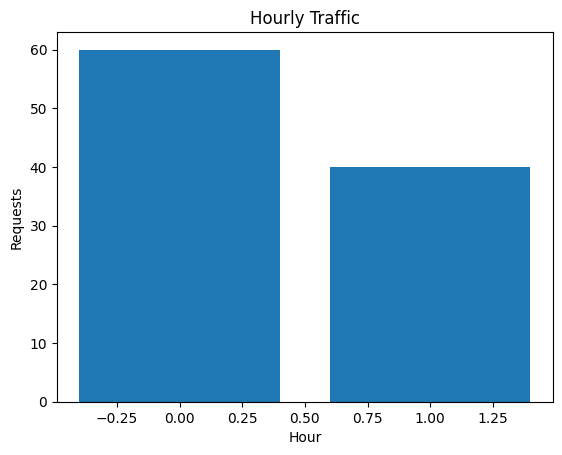

In [15]:
import matplotlib.pyplot as plt

traffic = df_with_time.groupBy("hour").count().orderBy("hour").toPandas()
plt.bar(traffic['hour'], traffic['count'])
plt.xlabel("Hour")
plt.ylabel("Requests")
plt.title("Hourly Traffic")
plt.show()


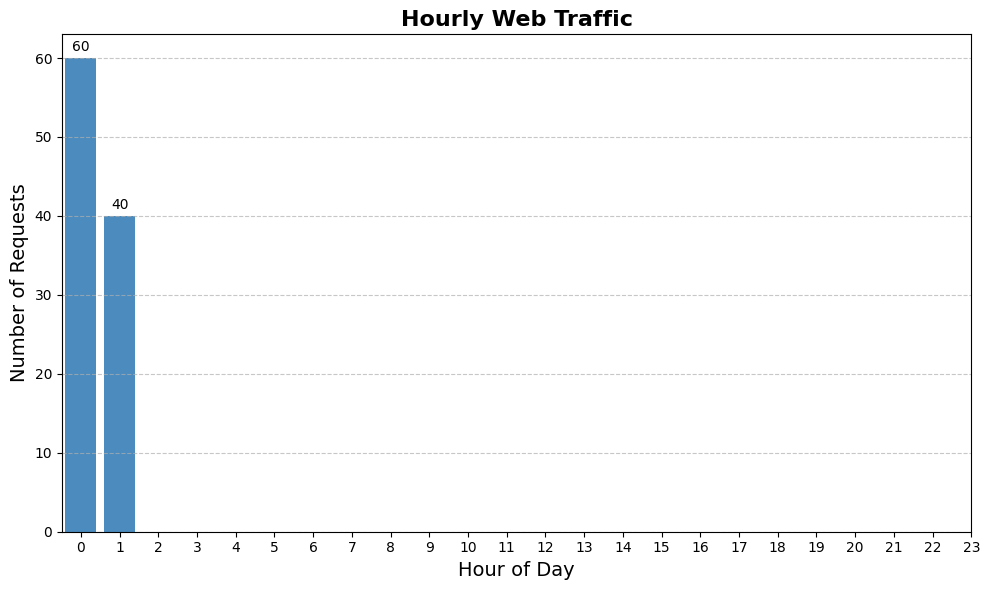

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Suppose traffic['hour'] is int 0-23
fig, ax = plt.subplots(figsize=(10,6))
bars = ax.bar(traffic['hour'], traffic['count'], color="#4b8bbe")

# Set x-axis as all 0-23 to show gaps as zeros if any hours are missing in the data
ax.set_xticks(np.arange(0, 24, 1))
ax.set_xticklabels(np.arange(0, 24, 1))
ax.set_xlabel("Hour of Day", fontsize=14)
ax.set_ylabel("Number of Requests", fontsize=14)
ax.set_title("Hourly Web Traffic", fontsize=16, fontweight='bold')
ax.yaxis.grid(True, linestyle='--', alpha=0.7)

# Annotate bars
for bar in bars:
    height = bar.get_height()
    if height > 0:
        ax.annotate('{}'.format(height),
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0,3), # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


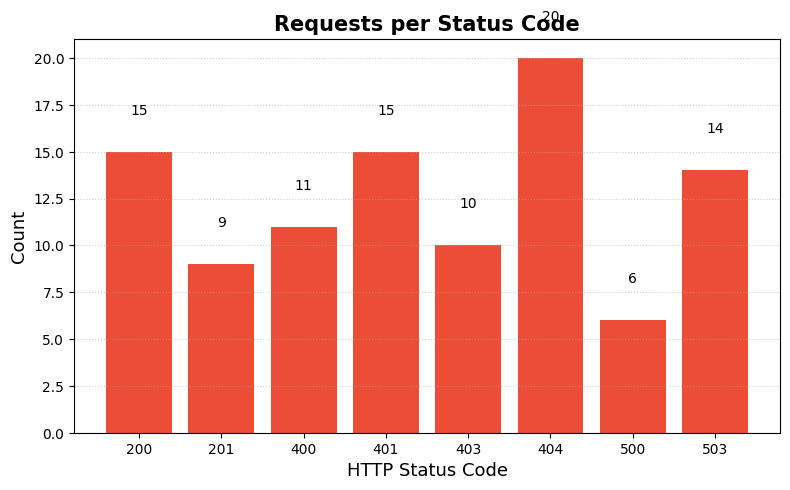

In [17]:
status_counts = df.groupBy("status").count().orderBy("status").toPandas()
plt.figure(figsize=(8,5))
plt.bar(status_counts['status'].astype(str), status_counts['count'], color="#ec4d37")
plt.xlabel("HTTP Status Code", fontsize=13)
plt.ylabel("Count", fontsize=13)
plt.title("Requests per Status Code", fontsize=15, fontweight='bold')
plt.grid(axis='y', linestyle=':', alpha=0.6)
for idx, val in enumerate(status_counts['count']):
    plt.text(idx, val+2, str(val), ha='center', fontsize=10)
plt.tight_layout()
plt.show()


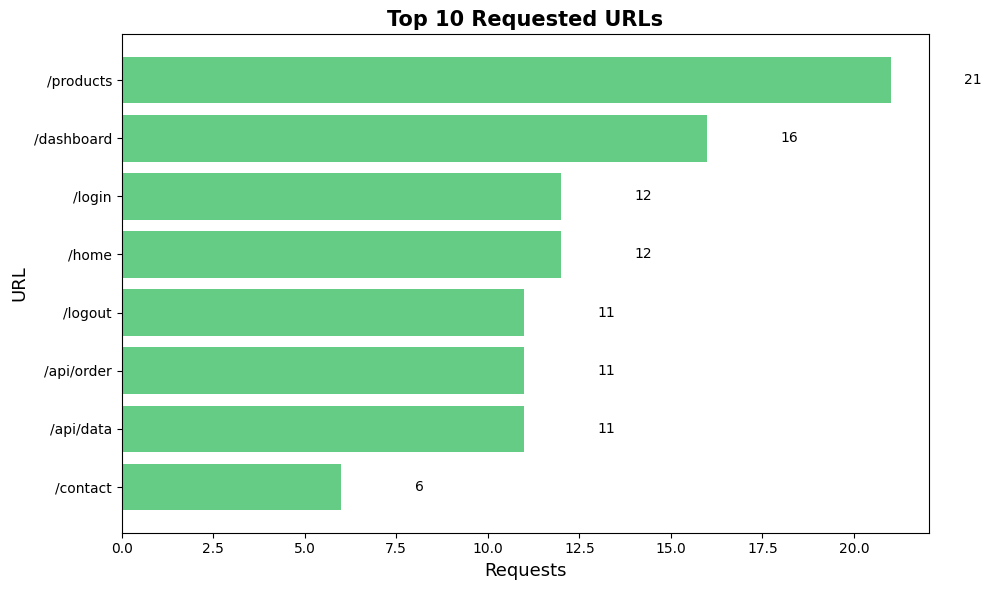

In [18]:
top_urls = df.groupBy("url").count().orderBy("count", ascending=False).limit(10).toPandas()
plt.figure(figsize=(10,6))
bars = plt.barh(top_urls['url'], top_urls['count'], color="#64cc85")
plt.xlabel("Requests", fontsize=13)
plt.ylabel("URL", fontsize=13)
plt.title("Top 10 Requested URLs", fontsize=15, fontweight='bold')
plt.gca().invert_yaxis()
for bar in bars:
    plt.text(bar.get_width()+2, bar.get_y()+bar.get_height()/2, str(int(bar.get_width())), va='center')
plt.tight_layout()
plt.show()


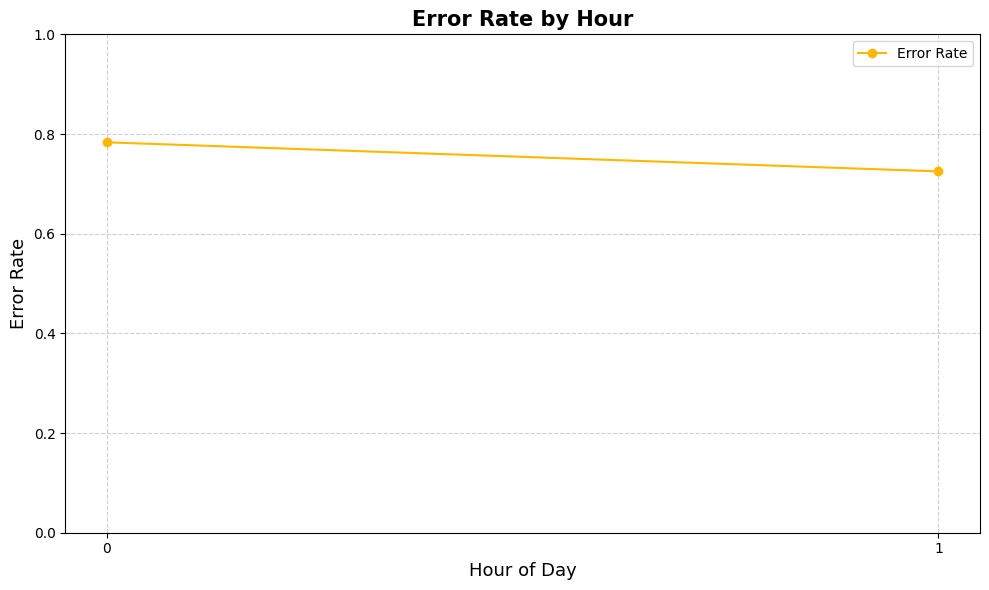

In [19]:
from pyspark.sql.functions import col, coalesce, lit

# Reuse df_with_time which already has the 'hour' column extracted using PySpark
# Filter for error logs (status >= 400) using PySpark
error_df_spark = df_with_time.filter(col('status') >= 400)

# Calculate total requests per hour using PySpark
total_requests_per_hour_spark = df_with_time.groupBy('hour').count().orderBy('hour')

# Calculate error requests per hour using PySpark
error_requests_per_hour_spark = error_df_spark.groupBy('hour').count().orderBy('hour')

# Join the two DataFrames to calculate the error rate
# Use a left outer join from total requests to error requests to include hours with no errors
error_rate_by_hour_spark = total_requests_per_hour_spark.join(
    error_requests_per_hour_spark,
    on='hour',
    how='left_outer'
).select(
    total_requests_per_hour_spark.hour,
    (coalesce(error_requests_per_hour_spark['count'], lit(0)) / total_requests_per_hour_spark['count']).alias('error_rate')
).orderBy('hour')

# Convert the result to pandas for plotting
error_by_hour_pandas = error_rate_by_hour_spark.toPandas()

import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(error_by_hour_pandas['hour'], error_by_hour_pandas['error_rate'], marker='o', color='#ffb800', label='Error Rate')
plt.xlabel("Hour of Day", fontsize=13)
plt.ylabel("Error Rate", fontsize=13)
plt.title("Error Rate by Hour", fontsize=15, fontweight='bold')
plt.ylim(0, 1)
plt.xticks(error_by_hour_pandas['hour']) # Ensure all hours with data are shown on x-axis
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

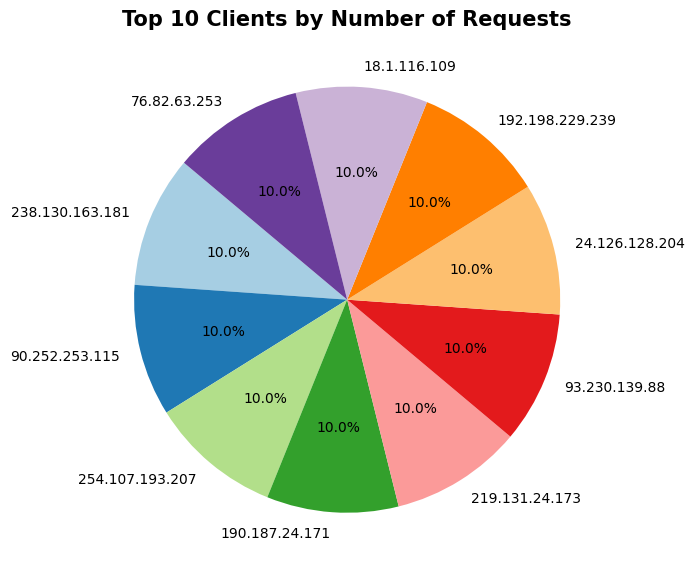

In [20]:
top_ips = df.groupBy("ip").count().orderBy("count", ascending=False).limit(10).toPandas()
plt.figure(figsize=(7,7))
plt.pie(top_ips['count'], labels=top_ips['ip'], autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
plt.title("Top 10 Clients by Number of Requests", fontsize=15, fontweight='bold')
plt.tight_layout()
plt.show()
